# LSTM

In [1]:
import pandas as pd
from pandas import DatetimeIndex
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import math
from math import sqrt
import seaborn as sns
import pandas_datareader as web
import datetime
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
sns.set(style='darkgrid', context='talk', palette='Dark2')
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
plt.rcParams['figure.figsize'] = (15, 9)
%matplotlib inline

Using TensorFlow backend.


In [2]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 1, 1)
amzn_df = web.DataReader('AMZN', 'yahoo', start, end)
amzn_df.tail(20)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-03,1772.869995,1747.229980,1760.000000,1769.959961,3380900,1769.959961
2019-12-04,1789.089966,1760.219971,1774.010010,1760.689941,2670100,1760.689941
2019-12-05,1763.500000,1740.000000,1763.500000,1740.479980,2823800,1740.479980
2019-12-06,1754.400024,1740.130005,1751.199951,1751.599976,3117400,1751.599976
2019-12-09,1766.890015,1745.609985,1750.660034,1749.510010,2442800,1749.510010
2019-12-10,1750.670044,1735.000000,1747.400024,1739.209961,2514300,1739.209961
2019-12-11,1750.000000,1735.709961,1741.670044,1748.719971,2097600,1748.719971
2019-12-12,1764.000000,1745.439941,1750.000000,1760.329956,3095900,1760.329956
2019-12-13,1768.989990,1755.000000,1765.000000,1760.939941,2745700,1760.939941


In [3]:
# Correlation matrix
amzn_df.corr()['Close']

High         0.999780
Low          0.999805
Open         0.999567
Close        1.000000
Volume       0.104311
Adj Close    1.000000
Name: Close, dtype: float64

In [4]:
amzn_df.describe().Volume

count    1.510000e+03
mean     4.172356e+06
std      2.291493e+06
min      8.813000e+05
25%      2.720875e+06
50%      3.560800e+06
75%      4.808650e+06
max      2.385610e+07
Name: Volume, dtype: float64

In [5]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [6]:
#Build and train the model
def fit_model(train,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []

  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  

    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch)
    model.reset_states()
    return model

In [7]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat

In [8]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Close Price Prediction using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [9]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

## Model Building

In [10]:
# Extracting the series
amzn = amzn_df[['Close','High','Low','Open','Volume']] # Picking the series with high correlation
print(amzn.shape)
print(amzn.tail(20))

(1510, 5)
                  Close         High          Low         Open   Volume
Date                                                                   
2019-12-03  1769.959961  1772.869995  1747.229980  1760.000000  3380900
2019-12-04  1760.689941  1789.089966  1760.219971  1774.010010  2670100
2019-12-05  1740.479980  1763.500000  1740.000000  1763.500000  2823800
2019-12-06  1751.599976  1754.400024  1740.130005  1751.199951  3117400
2019-12-09  1749.510010  1766.890015  1745.609985  1750.660034  2442800
2019-12-10  1739.209961  1750.670044  1735.000000  1747.400024  2514300
2019-12-11  1748.719971  1750.000000  1735.709961  1741.670044  2097600
2019-12-12  1760.329956  1764.000000  1745.439941  1750.000000  3095900
2019-12-13  1760.939941  1768.989990  1755.000000  1765.000000  2745700
2019-12-16  1769.209961  1769.500000  1757.050049  1767.000000  3145200
2019-12-17  1790.660034  1792.000000  1777.390015  1778.010010  3644400
2019-12-18  1784.030029  1798.199951  1782.359985  179

In [11]:
#Train Val Test Split
train_start = '2014-01-01'
train_end = '2018-12-31'
train_data = amzn.loc[train_start:train_end]

test_start = '2019-01-01'
test_end = '2020-01-01'
test_data = amzn.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1258, 5) (252, 5)


In [12]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
test = sc.transform(test_data)
print(train.shape,test.shape)

(1258, 5) (252, 5)


In [13]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 50
num_epochs = 150

In [14]:
model= fit_model(train,timesteps,hl,lr,batch_size,num_epochs)

Epoch 1/150
1208/1208 [==============================] - 5s 4ms/step - loss: 0.0907
Epoch 2/150
1208/1208 [==============================] - 3s 2ms/step - loss: 0.0111
Epoch 3/150
1208/1208 [==============================] - 2s 2ms/step - loss: 0.0040
Epoch 4/150
1208/1208 [==============================] - 3s 2ms/step - loss: 0.0019
Epoch 5/150
1208/1208 [==============================] - 3s 2ms/step - loss: 0.0017
Epoch 6/150
1208/1208 [==============================] - 3s 2ms/step - loss: 0.0016
Epoch 7/150
1208/1208 [==============================] - 3s 2ms/step - loss: 9.7550e-04
Epoch 8/150
1208/1208 [==============================] - 2s 2ms/step - loss: 9.2227e-04
Epoch 9/150
1208/1208 [==============================] - 3s 2ms/step - loss: 8.7080e-04
Epoch 10/150
1208/1208 [==============================] - 2s 2ms/step - loss: 8.2223e-04
Epoch 11/150
1208/1208 [==============================] - 3s 2ms/step - loss: 8.6470e-04
Epoch 12/150
1208/1208 [==============================

1208/1208 [==============================] - 2s 2ms/step - loss: 4.1251e-04
Epoch 94/150
1208/1208 [==============================] - 2s 2ms/step - loss: 4.0427e-04
Epoch 95/150
1208/1208 [==============================] - 2s 2ms/step - loss: 3.9788e-04
Epoch 96/150
1208/1208 [==============================] - 2s 2ms/step - loss: 5.5016e-04
Epoch 97/150
1208/1208 [==============================] - 2s 2ms/step - loss: 4.0223e-04
Epoch 98/150
1208/1208 [==============================] - 2s 2ms/step - loss: 6.0869e-04
Epoch 99/150
1208/1208 [==============================] - 2s 2ms/step - loss: 4.4940e-04
Epoch 100/150
1208/1208 [==============================] - 2s 2ms/step - loss: 4.0279e-04
Epoch 101/150
1208/1208 [==============================] - 2s 2ms/step - loss: 3.7190e-04
Epoch 102/150
1208/1208 [==============================] - 2s 2ms/step - loss: 4.0711e-04
Epoch 103/150
1208/1208 [==============================] - 2s 2ms/step - loss: 3.8993e-04
Epoch 104/150
1208/1208 [=====

MSE = 0.00037638367555503546
RMSE = 0.019400610185121382
R-Squared Score = 0.7929076204865854


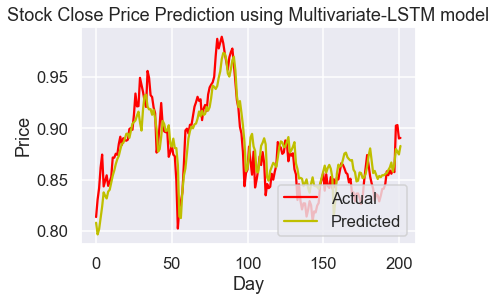

In [15]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)